In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"C:\Users\moral\Dropbox\Panda\WORK\Research\FSPM\Virtual_Plant_Laboratory\Julia\VPLsite\tutorials\growth_forest"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
using VPL
using Base.Threads: @threads
using Plots
import Random
using FastGaussQuadrature
using Distributions
Random.seed!(123456789)

Random.TaskLocalRNG()

In [3]:
# Data types
module TreeTypes
    using VPL
    using Distributions
    # Meristem
    Base.@kwdef mutable struct Meristem <: VPL.Node 
        age::Int64 = 0   # Age of the meristem
    end
    # Bud
    struct Bud <: VPL.Node end
    # Node
    struct Node <: VPL.Node end
    # BudNode
    struct BudNode <: VPL.Node end
    # Internode (needs to be mutable to allow for changes over time)
    Base.@kwdef mutable struct Internode <: VPL.Node
        age::Int64 = 0         # Age of the internode
        biomass::Float64 = 0.0 # Initial biomass
        length::Float64 = 0.0  # Internodes
        width::Float64  = 0.0  # Internodes
        sink::Exponential{Float64} = Exponential(5)
    end
    # Leaf
    Base.@kwdef mutable struct Leaf <: VPL.Node
        age::Int64 = 0         # Age of the leaf
        biomass::Float64 = 0.0 # Initial biomass
        length::Float64 = 0.0  # Leaves
        width::Float64 = 0.0   # Leaves
        sink::Beta{Float64} = Beta(2,5)
    end    
    # Graph-level variables -> mutable because we need to modify them during growth
    Base.@kwdef mutable struct treeparams
        # Variables
        biomass::Float64 = 2e-3 # Current total biomass (g)
        # Parameters
        RGR::Float64 = 1.0   # Relative growth rate (1/d)
        IB0::Float64 = 1e-3  # Initial biomass of an internode (g)
        SIW::Float64 = 0.1e6   # Specific internode weight (g/m3)
        IS::Float64  = 15.0  # Internode shape parameter (length/width)
        LB0::Float64 = 1e-3  # Initial biomass of a leaf
        SLW::Float64 = 100.0 # Specific leaf weight (g/m2)
        LS::Float64  = 3.0   # Leaf shape parameter (length/width)
        budbreak::Float64 = 1/0.5 # Bud break probability coefficient (in 1/m) 
        plastochron::Int64 = 5 # Number of days between phytomer production 
        leaf_expansion::Float64 = 15.0 # Number of days that a leaf expands
        phyllotaxis::Float64 = 140.0
        leaf_angle::Float64 = 30.0
        branch_angle::Float64 = 45.0
    end
end

import .TreeTypes

In [4]:
# Create geometry + color for the internodes
function VPL.feed!(turtle::Turtle, i::TreeTypes.Internode, vars)
    # Rotate turtle around the head to implement elliptical phyllotaxis
    rh!(turtle, vars.phyllotaxis) 
    HollowCylinder!(turtle, length = i.length, height = i.width, width = i.width, 
                move = true, color = RGB(0.5,0.4,0.0))
    return nothing
end

# Create geometry + color for the leaves
function VPL.feed!(turtle::Turtle, l::TreeTypes.Leaf, vars)
    # Rotate turtle around the arm for insertion angle
    ra!(turtle, -vars.leaf_angle)
    # Generate the leaf 
    Ellipse!(turtle, length = l.length, width = l.width, move = false, 
             color = RGB(0.2,0.6,0.2))
    # Rotate turtle back to original direction
    ra!(turtle, vars.leaf_angle)
    return nothing
end

# Insertion angle for the bud nodes
function VPL.feed!(turtle::Turtle, b::TreeTypes.BudNode, vars)
    # Rotate turtle around the arm for insertion angle
    ra!(turtle, -vars.branch_angle)
end

In [5]:
# Create right side of the growth rule (parameterized by the initial states
# of the leaves and internodes)
function create_meristem_rule(vleaf, vint)
    meristem_rule = Rule(TreeTypes.Meristem, 
                        lhs = mer -> mod(data(mer).age, vars(mer).plastochron) == 0,
                        rhs = mer -> TreeTypes.Node() + 
                                     (TreeTypes.Bud(), 
                                     TreeTypes.Leaf(biomass = vleaf.biomass, 
                                                    length  = vleaf.length,
                                                    width   = vleaf.width)) +
                                     TreeTypes.Internode(biomass = vint.biomass, 
                                                         length  = vint.length,
                                                         width   = vint.width) + 
                                     TreeTypes.Meristem())
end

create_meristem_rule (generic function with 1 method)

In [6]:
# Compute the probability that a bud breaks as function of distance to the meristem
function prob_break(bud)
    # We move to parent node in the branch where the bud was created
    node =  parent(bud)
    # Extract the first internode
    child = filter(x -> data(x) isa TreeTypes.Internode, children(node))[1]
    data_child = data(child)
    # We measure the length of the branch until we find the meristem
    distance = 0.0
    while !isa(data_child, TreeTypes.Meristem)
        # If we encounter an internode, store the length and move to the next node
        if data_child isa TreeTypes.Internode
            distance += data_child.length
            child = children(child)[1]
            data_child = data(child)
        # If we encounter a node, extract the next internode    
        elseif data_child isa TreeTypes.Node
                child = filter(x -> data(x) isa TreeTypes.Internode, children(child))[1]
                data_child = data(child)
        else
            error("Should be Internode, Node or Meristem")
        end
    end
    # Compute the probability of bud break as function of distance and 
    # make stochastic decision
    prob =  min(1.0, distance*vars(bud).budbreak)
    return rand() < prob
end

# Branch rule parameterized by initial states of internodes
function create_branch_rule(vint)
    branch_rule = Rule(TreeTypes.Bud, 
            lhs = prob_break, 
            rhs = bud -> TreeTypes.BudNode() + 
                         TreeTypes.Internode(biomass = vint.biomass, 
                                             length  = vint.length,
                                             width   = vint.width) +
                         TreeTypes.Meristem())
end

create_branch_rule (generic function with 1 method)

In [7]:
function leaf_dims(biomass, vars)
    leaf_biomass = biomass
    leaf_area    = biomass/vars.SLW
    leaf_length  = sqrt(leaf_area*4*vars.LS/pi)
    leaf_width   = leaf_length/vars.LS
    return leaf_length, leaf_width
end

function int_dims(biomass, vars)
    int_biomass = biomass
    int_volume  = biomass/vars.SIW
    int_length  = cbrt(int_volume*4*vars.IS^2/pi)
    int_width   = int_length/vars.IS
    return int_length, int_width
end

int_dims (generic function with 1 method)

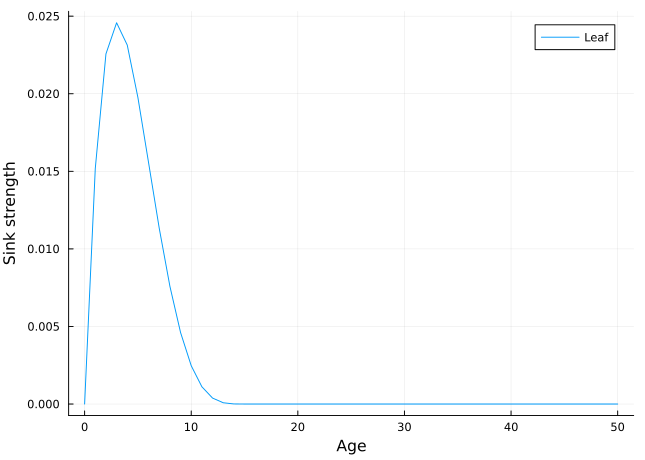

In [8]:
sink_strength(leaf, vars) = leaf.age > vars.leaf_expansion ? 0.0 :  
                            pdf(leaf.sink, leaf.age/vars.leaf_expansion)/100.0
plot(0:1:50, x -> sink_strength(TreeTypes.Leaf(age = x), TreeTypes.treeparams()), 
     xlabel = "Age", ylabel = "Sink strength", label = "Leaf")

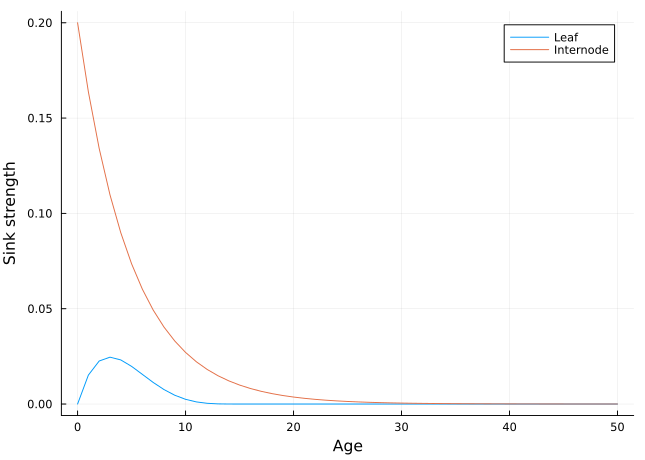

In [9]:
sink_strength(int) = pdf(int.sink, int.age)
plot!(0:1:50, x -> sink_strength(TreeTypes.Internode(age = x)), label = "Internode")

In [10]:
get_leaves(tree) = apply(tree, Query(TreeTypes.Leaf))
get_internodes(tree) = apply(tree, Query(TreeTypes.Internode))

get_internodes (generic function with 1 method)

In [11]:
function age!(all_leaves, all_internodes, all_meristems)
    for leaf in all_leaves
        leaf.age += 1
    end
    for int in all_internodes
        int.age += 1
    end
    for mer in all_meristems
        mer.age += 1
    end
    return nothing
end

age! (generic function with 1 method)

In [12]:
function grow!(tree, all_leaves, all_internodes)
    # Compute total biomass increment
    tvars = vars(tree)
    ΔB    = tvars.RGR*tvars.biomass
    tvars.biomass += ΔB
    # Total sink strength
    total_sink = 0.0
    for leaf in all_leaves
        total_sink += sink_strength(leaf, tvars)
    end
    for int in all_internodes
        total_sink += sink_strength(int)
    end
    # Allocate biomass to leaves and internodes
    for leaf in all_leaves
        leaf.biomass += ΔB*sink_strength(leaf, tvars)/total_sink
    end
    for int in all_internodes
        int.biomass += ΔB*sink_strength(int)/total_sink
    end
    return nothing
end

grow! (generic function with 1 method)

In [13]:
function size_leaves!(all_leaves, tvars)
    for leaf in all_leaves
        leaf.length, leaf.width = leaf_dims(leaf.biomass, tvars)
    end
    return nothing
end
function size_internodes!(all_internodes, tvars)
    for int in all_internodes
        int.length, int.width = int_dims(int.biomass, tvars)
    end
    return nothing
end

size_internodes! (generic function with 1 method)

In [14]:
get_meristems(tree) = apply(tree, Query(TreeTypes.Meristem))
function daily_step!(forest)
    @threads for tree in forest
        # Retrieve all the relevant organs
        all_leaves = get_leaves(tree)
        all_internodes = get_internodes(tree)
        all_meristems = get_meristems(tree)
        # Update the age of the organs
        age!(all_leaves, all_internodes, all_meristems)
        # Grow the tree
        grow!(tree, all_leaves, all_internodes)
        tvars = vars(tree)
        size_leaves!(all_leaves, tvars)
        size_internodes!(all_internodes, tvars)
        # Developmental rules
        rewrite!(tree)
    end
end

daily_step! (generic function with 1 method)

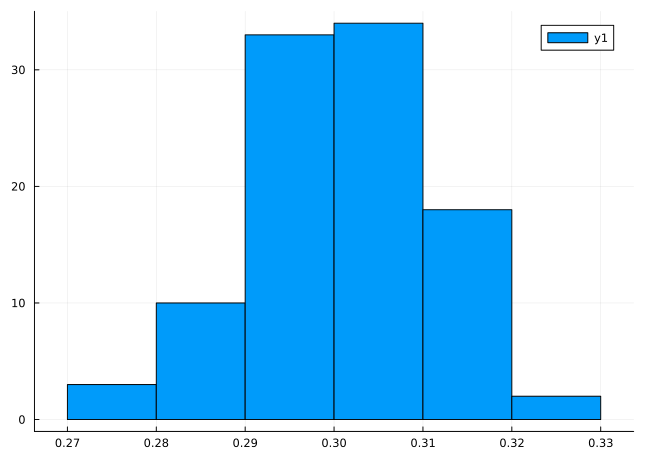

In [15]:
RGRs = rand(Normal(0.3,0.01), 10, 10)
histogram(vec(RGRs))

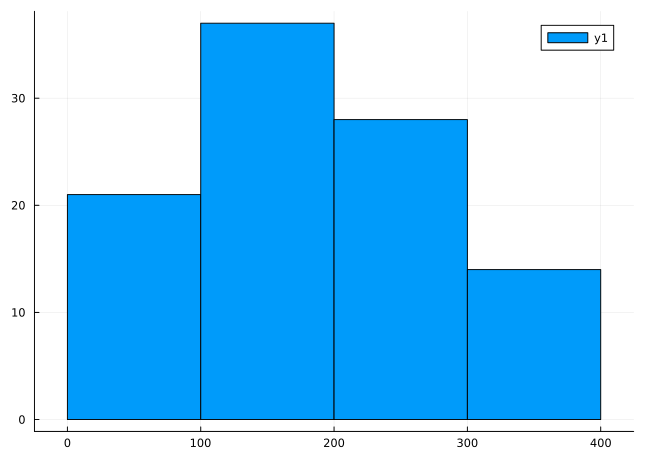

In [16]:
orientations = [rand()*360.0 for i = 1:2.0:20.0, j = 1:2.0:20.0]
histogram(vec(orientations))

In [17]:
origins = [Vec(i,j,0) for i = 1:2.0:20.0, j = 1:2.0:20.0];

In [18]:
function create_tree(origin, orientation, RGR)
    # Initial state and parameters of the tree
    vars = TreeTypes.treeparams(RGR = RGR)
    # Initial states of the leaves
    leaf_length, leaf_width = leaf_dims(vars.LB0, vars)
    vleaf = (biomass = vars.LB0, length = leaf_length, width = leaf_width)
    # Initial states of the internodes
    int_length, int_width = int_dims(vars.LB0, vars)
    vint = (biomass = vars.IB0, length = int_length, width = int_width)
    # Growth rules
    meristem_rule = create_meristem_rule(vleaf, vint)
    branch_rule   = create_branch_rule(vint)
    axiom = T(origin) + RH(orientation) +
            TreeTypes.Internode(biomass = vint.biomass,
                             length  = vint.length,
                             width   = vint.width) +
            TreeTypes.Meristem()
    tree = Graph(axiom = axiom, rules = (meristem_rule, branch_rule), 
                 vars = vars)
    return tree
end

create_tree (generic function with 1 method)

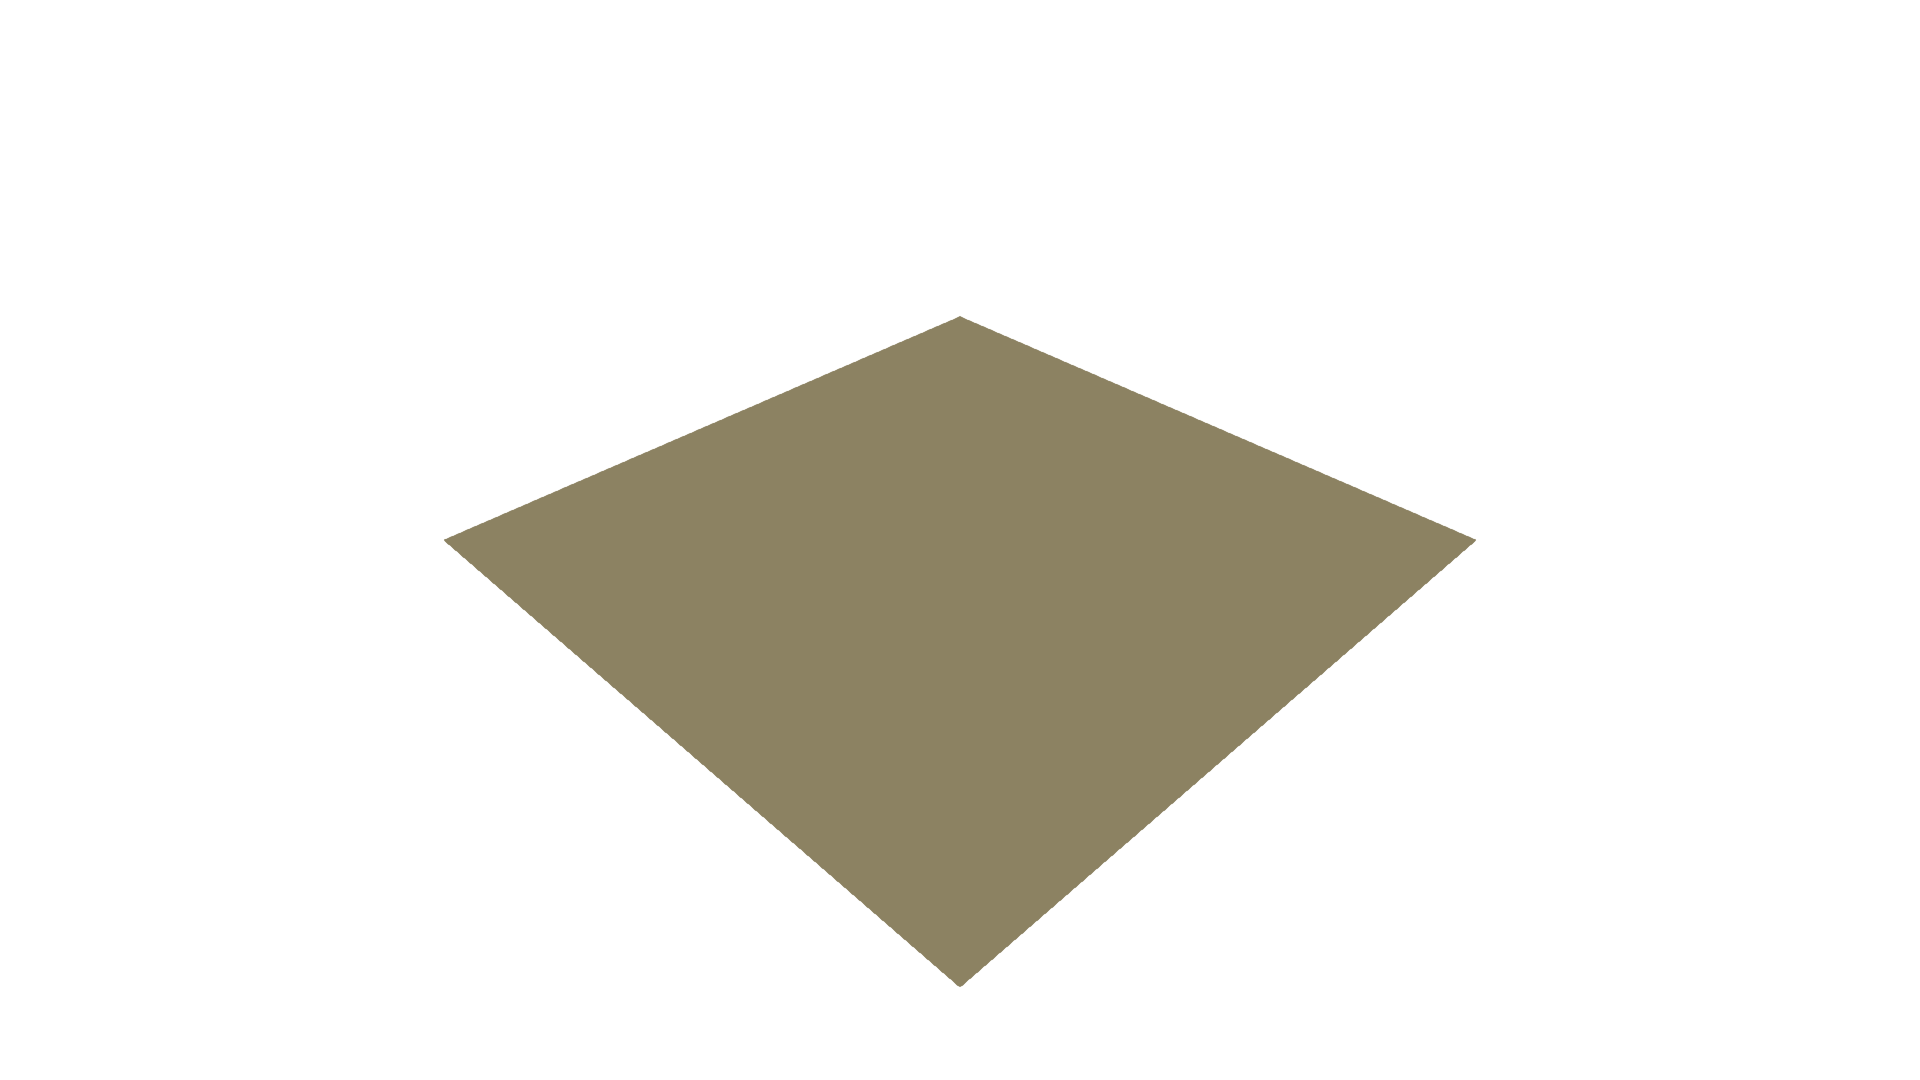

In [19]:
Base.@kwdef struct Soil <: VPL.Node
    length::Float64 
    width::Float64
end
function VPL.feed!(turtle::Turtle, s::Soil, vars)
    Rectangle!(turtle, length = s.length, width = s.width, color = RGB(255/255, 236/255, 179/255))
end
soil_graph = RA(-90.0) + T(Vec(0.0, 10.0, 0.0)) + # Moves into position
             Soil(length = 20.0, width = 20.0) # Draws the soil tile
soil = Scene(Graph(axiom = soil_graph));
render(soil, axes = false)

In [20]:
function render_forest(forest, soil)
    scene = Scene(vec(forest)) # create scene from forest
    scene = Scene([scene, soil]) # merges the two scenes
    render(scene)
end

render_forest (generic function with 1 method)

In [21]:
function get_LAI(forest)
    LAI = 0.0
    @threads for tree in forest
        for leaf in get_leaves(tree)
            LAI += leaf.length*leaf.width*pi/4.0
        end
    end
    return LAI/400.0
end

get_LAI (generic function with 1 method)

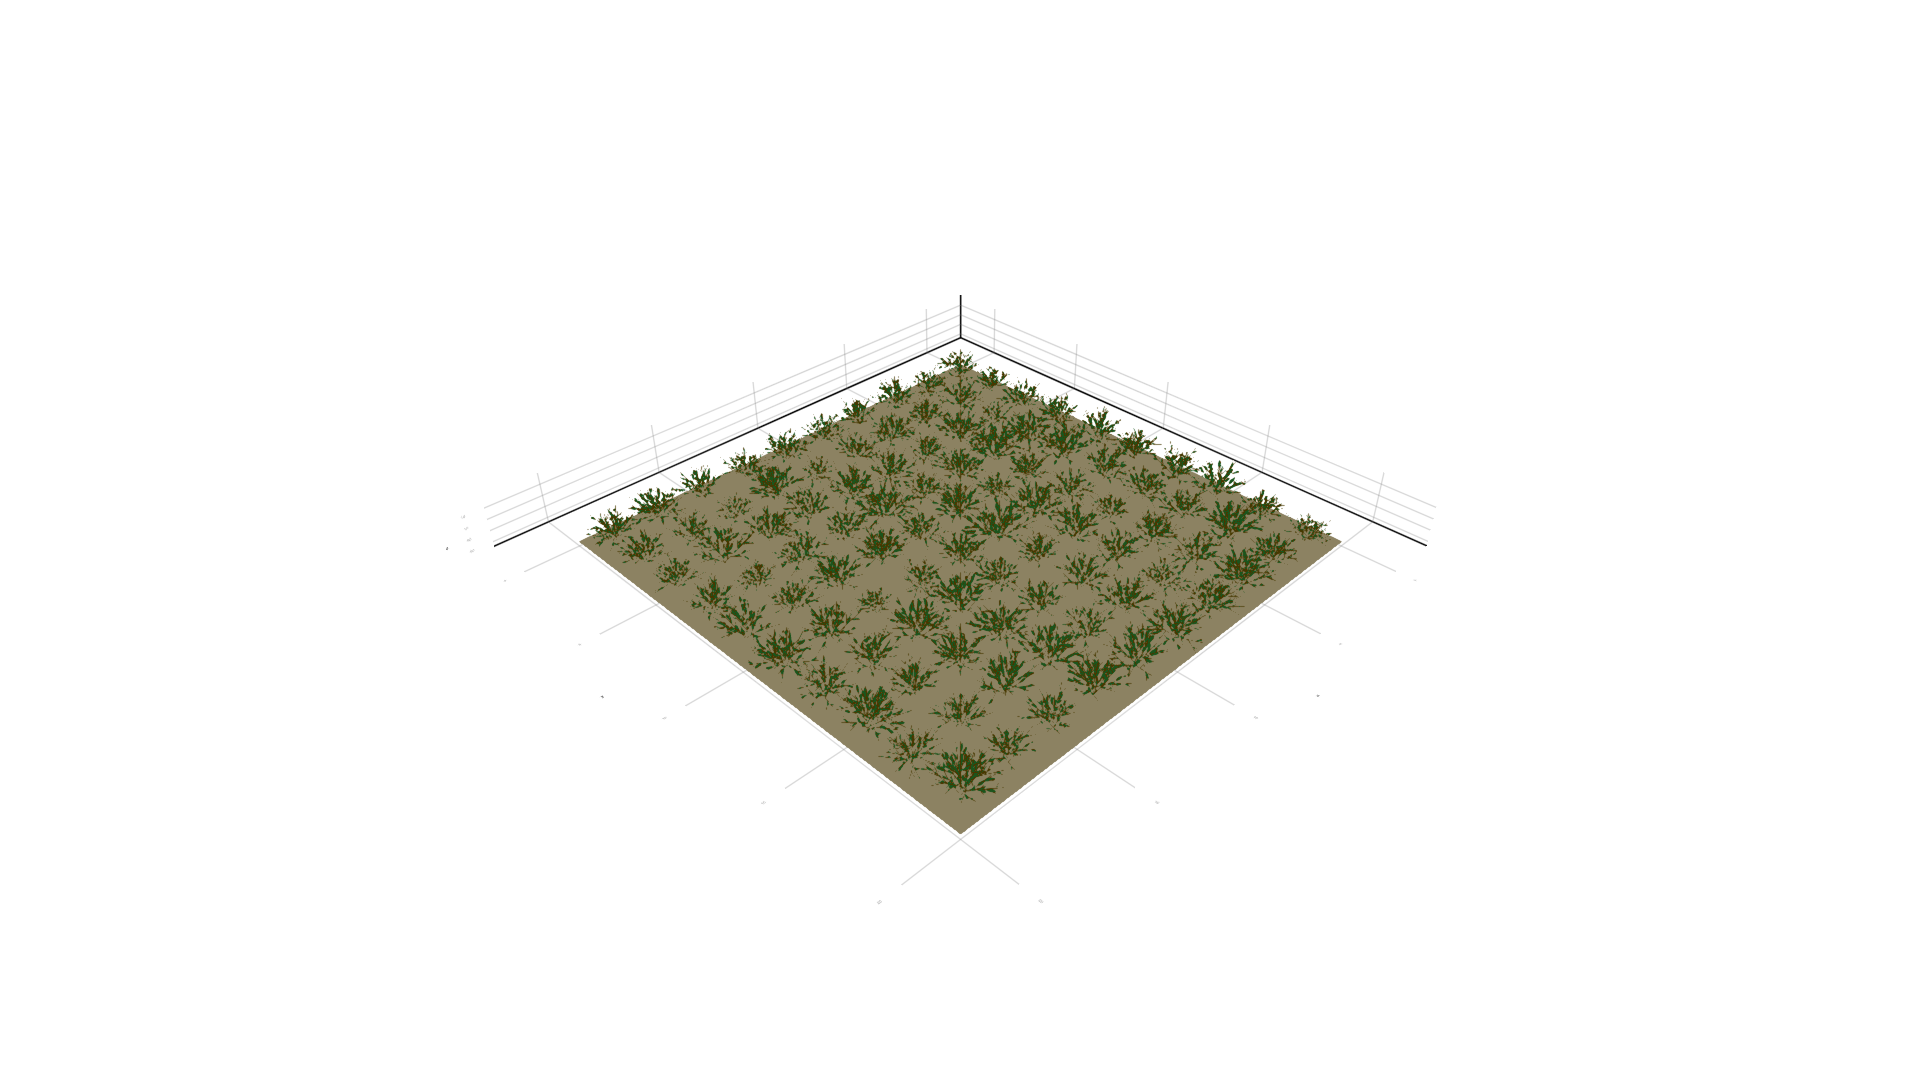

In [22]:
forest = create_tree.(origins, orientations, RGRs);
render_forest(forest, soil)
for i in 1:50
    daily_step!(forest)
end
render_forest(forest, soil)

In [23]:
get_LAI(forest)

0.1444666725606486